# PPO for Mujoco

This is a reduced version of PPO as used for MuJoCO (at least how I understand it).

This means:
- counting time-steps rather than episodes
- collection of many time steps, even if it means that several episodes are collected
- use of GAE($\lambda$)
- Clip objective
- several gradient steps on mini-batches of the collected data
- importance sampling correction

By my interpretation, several pieces of the full PPO algorithm are not used for MuJoCo (e.g., see Table 3 on page 10 of [the PPO paper](https://arxiv.org/abs/1707.06347)):
- no mention of more than one actor
- no mention of use of KL divergence or adaptive KL step-size, or entropy bonus, in the best result (see Table 1, and compare hyper-parameter settings for Roboschool and Atari, Tables 4 and 5, where there is mention of these approaches, but not for MuJoCo)
We'll introduce these techniques in separate notebooks.

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RescaleAction

import numpy as np

import torch
from torch import nn

from torchrl.modules import TruncatedNormal # continous bounded action space

import copy # to save the old policy
import random # sample losses

import matplotlib.pyplot as plt

In [ ]:
# The policy needs to be modified to return a mean tensor and a standard deviations tensor
# - use logits as mean
# - standard deviations separate
# - no dependencies between dimensions of multi-variate normal distribution
class Policy(nn.Module):
    def __init__(self, n_in, n_hidden1, n_hidden2, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden1),
            nn.Tanh(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.Tanh(),
            nn.Linear(n_hidden2, n_out),
        )

        # From PPO, page 6: 
        # "To represent the policy, we used a fully-connected MLP with two hidden layers of 64 units,
        # and tanh nonlinearities, outputting the mean of a Gaussian distribution, with variable standard
        # deviations, following [Sch+15b; Dua+16]."
        # (See [Sch+15b] (Trust Region Policy Optimization) on page 15.)
        # Initialization of the standard deviations is not fully clear here, 
        # but to initialize them to 1 seems a reasonable first guess.
        self.log_stddevs = nn.Parameter(torch.zeros(n_out))
    
    def forward(self, x):
        logits = self.net(x)
        stddevs = torch.exp(self.log_stddevs)
        return logits, stddevs
    
class Value(nn.Module):
    def __init__(self, n_in, n_hidden1, n_hidden2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden1),
            nn.Tanh(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.Tanh(),
            nn.Linear(n_hidden2, 1), # same as Policy, but output is only one number
        )
    
    def forward(self, x): 
        logit = self.net(x)
        return logit

In [4]:
# Possible environments
envs = [
    # Continuous environments in Gymnasium:
    # "Pendulum-v1",
    # "MountainCarContinuous-v0",
    # "BipedalWalker-v3",
    # "LunarLander-v3",
    # "CarRacing-v3", # image input
    
    # Mujoco environments used by PPO (with updated version numbers):
    "HalfCheetah-v5",
    "Hopper-v5",
    "InvertedDoublePendulum-v5",
    "InvertedPendulum-v5",
    "Reacher-v5",
    "Swimmer-v5",
    "Walker2d-v5"
]

In [ ]:
seed = 42
env_name = "InvertedDoublePendulum-v5"

n_hidden1 = 64 
n_hidden2 = 64

gamma = 0.99
gae_lambda = 0.95 # New parameter for generalized advantage estimation

eps = 0.2 # New clipping parameter

# Sutton & Barto use a separate learning rate to update the state-value function parameters
# PPO has the same learning rate for both policy and value function
alpha = 3e-4

n_steps = 100_000 # should be 1_000_000
T = 2048 # should be 2048
n_epochs = 10 # should be 10
minibatch_size = 64 # should be 64

print_every_n_episodes = 1000

In [24]:
np.random.seed(seed)
torch.manual_seed(seed)

# Initialise the environment
env = gym.make(env_name, continuous=True) if env_name in ["LunarLander-v3", "CarRacing-v3"] else gym.make(env_name)
env = RescaleAction(env, min_action=-1, max_action=1)

# Reset the environment to generate the first observation
observation, info = env.reset(seed=seed)
observation = torch.tensor(observation, requires_grad=False, dtype=torch.float32)

policy = Policy(n_in=env.observation_space.shape[0], n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_out=env.action_space.shape[0])

# The state-value function maps states to a single number. From PPO: "We don’t share parameters between the policy and value function [...]". 
value = Value(n_in=env.observation_space.shape[0], n_hidden1=n_hidden1, n_hidden2=n_hidden2)

# Sutton & Barto use separate gradient update steps with separate learning rates for the policy and the state-value function
# PPO has the same learning rate for both policy and value function
optimizer = torch.optim.Adam(list(policy.parameters()) + list(value.parameters()), lr=alpha, maximize=True)

all_episode_rewards = []


i_global_timestep = 1
while i_global_timestep <= n_steps:

    # track information for roll-outs in the form of nested lists, where the total number of elements is T, 
    # and the inner lists are episodes
    rewards_horizon = []
    observations_horizon = []
    actions_horizon = []
    values_horizon = [] # also track the value function
    
    # informaton per episode, in the form (s_t, a_t) -> (r_t, s_{t+1})
    rewards_episode = [] # T rewards from 1 to T
    observations_episode = [observation] # T observations from 0 to T-1, the policy expects tensors as input
    actions_episode = [] # T actions from 0 to T-1
    values_episode = [value(observation)] # same as observations, but if episode ends one 0 will be appended

    # roll-out of episode(s) following the policy, for T total time-steps
    done = False
    i_horizon_timestep = 0
    while i_horizon_timestep < T:
        
        # probabilities for actions
        # The policy network outputs means and standard deviations
        pred_means, pred_stddevs = policy(observation)
        
        # sample an action according to the probabilities
        # We use the truncated normal distribution on the continuous action space, not the categorical distribution for a discrete set of actions
        TN = TruncatedNormal(loc=pred_means,
                            scale=pred_stddevs,
                            low=env.action_space.low,
                            high=env.action_space.high,
                            tanh_loc=False)
        action = TN.sample()

        # step (transition) through the environment with the action
        # receiving the next observation, reward and if the episode has terminated or truncated
        observation, reward, terminated, truncated, info = env.step(action.detach().numpy())
        i_horizon_timestep += 1
        observation = torch.tensor(observation, requires_grad=False, dtype=torch.float32)
        done = terminated or truncated

        # build up one episode
        rewards_episode.append(reward)
        observations_episode.append(observation)
        actions_episode.append(action)
        values_episode.append(value(observation)) # this is the observation after taking action

        # If the episode or the time-steps have ended then we can reset to start a new episode
        # The overall data collection won't exactly end at n_steps, but we avoid having too little data in the last batch
        if done or i_horizon_timestep == T:
            observation, info = env.reset()
            observation = torch.tensor(observation, requires_grad=False, dtype=torch.float32)
            
            # track quantities per episode
            rewards_horizon.append(rewards_episode)
            observations_horizon.append(observations_episode)
            actions_horizon.append(actions_episode)
            if done:
                values_episode[-1] = torch.zeros_like(values_episode[-1]) # value for next observation after termination should be 0
                all_episode_rewards.append(sum(rewards_episode)) # track total reward for all episodes

                # print some statistics after every n-th completed episode
                if len(all_episode_rewards) % print_every_n_episodes == 0:
                    print("\nStep:", i_global_timestep, "of", n_steps)
                    print("Alpha:", alpha, "Gamma:", gamma, "Lambda:", gae_lambda)
                    print("Episodes completed:", len(all_episode_rewards))
                    if len(all_episode_rewards) >= 100: print("Average reward last 100 episodes:", np.mean(all_episode_rewards[-100:]))

            values_horizon.append(values_episode)
            # and reset them for the next episode roll-out
            rewards_episode = [] # T rewards from 1 to T
            observations_episode = [observation] # T observations from 0 to T-1, the policy expects tensors as input
            actions_episode = []
            values_episode = [value(observation)]

            done = False # start new episode
    
    i_global_timestep += i_horizon_timestep 

    policy_old = copy.deepcopy(policy) # save the old policy


    # Pick the indices of the time-steps to be used to update the policy
    # Having the sampling outside the epoch loop corresponds to sampling without replacement (every time-step is used at most once)
    # Moving this inside the epoch loop will make it sampling with replacement (time-steps can be used more than once)
    loss_indices = list(range(T))
    random.shuffle(loss_indices)

    for i_epoch in range(n_epochs):
        
        # get time-steps that will be used in this mini-batch
        # custom version of sampling without replacement, but in a way that allows additional epochs even when all elements have already been sampled
        epoch_indices = loss_indices[:minibatch_size]
        del loss_indices[:minibatch_size] # "popleft"
        loss_indices.extend(epoch_indices) # and then insert back in


        # Calculate loss
        # We accumulate gradients over one mini-batch and make one gradient step per mini-batch
        pseudo_losses = []
        # We now unpack the nested list structure that stores the episode roll-outs
        rollouts_step_counter = -1 # we use this to filter out our mini-batch
        for i_ep, rewards_episode in enumerate(rewards_horizon):
            observations_episode = observations_horizon[i_ep]
            actions_episode = actions_horizon[i_ep]
            values_episode = values_horizon[i_ep]
            for t in range(len(rewards_episode)):
                rollouts_step_counter +=1 # We need to maintain the episode structure to calculate advantages as they access information in order until the end of the episode roll-out
                if rollouts_step_counter in epoch_indices: # this filters for mini-batch
                
                    observation = observations_episode[t]
                    action = actions_episode[t]

                    rewards_ge_t = rewards_episode[t:T]
                    values_ge_t = values_episode[t:T+1][:-1]
                    values_ge_tp1 = values_episode[t:T+1][1:]
                    
                    deltas_ge_t = [r + gamma*vnext - v for r,vnext,v in zip(rewards_ge_t, values_ge_t, values_ge_tp1)]

                    Advantage_t = sum((gamma * gae_lambda)**i * d for i, d in enumerate(deltas_ge_t)) # TODO Advantages don't change when updating the policy - don't recalculate them for every epoch

                    Advantage_t = Advantage_t.detach()

                    # log probs for this observation - action under updated policy
                    pred_means, pred_stddevs = policy(observation)
                    TN = TruncatedNormal(loc=pred_means,
                                        scale=pred_stddevs,
                                        low=env.action_space.low,
                                        high=env.action_space.high,
                                        tanh_loc=False)

                    log_prob = TN.log_prob(action).sum()

                    # log probs for this observation - action under old policy
                    pred_means_old, pred_stddevs_old = policy_old(observation)
                    TN_old = TruncatedNormal(loc=pred_means_old,
                                            scale=pred_stddevs_old,
                                            low=env.action_space.low,
                                            high=env.action_space.high,
                                            tanh_loc=False)

                    log_prob_old = TN_old.log_prob(action).sum().detach() # TODO can compute and store these during episode rollouts
                    
                    # ratio
                    r_t = torch.exp(log_prob - log_prob_old) # exp(log a - log b) = exp(log a) / exp(log b) = a / b

                    # Clipped objective
                    L_clip = torch.min(r_t*Advantage_t, torch.clamp(r_t, 1-eps, 1+eps)*Advantage_t)

                    # Value loss, now in form of MSE loss, using: V - V_target = Advantage = V - V + Advantage = V - (Advantage + V)
                    L_value = 0.5 * (value(observation) - (Advantage_t + values_episode[t].detach()))**2

                    pseudo_losses.append(L_clip - L_value) # collect the losses for each sampled time-step in this mini-batch


        pseudo_loss = torch.stack(pseudo_losses).mean()
        
        # Now one gradient step for the combined policy and value function loss
        optimizer.zero_grad()
        pseudo_loss.backward()
        optimizer.step()


env.close()


Step: 6145 of 10000
Alpha: 0.0003 Gamma: 0.99 Lambda: 0.95
Episodes completed: 1000
Average reward last 100 episodes: 58.87715441814157


### Save and load trained policies

In [ ]:
import pickle

# Uncomment to save a trained policy:
# pickle.dump(policy, open('policies/REINFORCE_with_baseline_InvertedDoublePendulum_visualize.pkl', 'wb'))

# Uncomment to load a saved policy:
# policy = pickle.load(open('policies/REINFORCE_with_baseline_InvertedDoublePendulum_visualize.pkl', 'rb'))

### Plotting training progress

Text(0.5, 1.0, 'InvertedDoublePendulum-v5\nReward threshold: 9100.0')

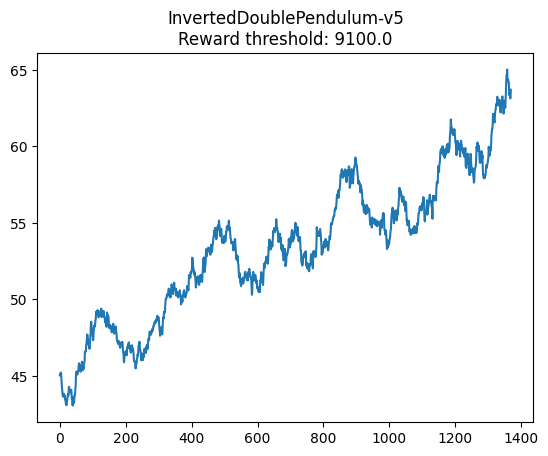

In [26]:
smoothing_interval = 100 # Change for different levels of smoothing
smoothed_rewards = np.convolve(all_episode_rewards, np.ones(smoothing_interval)/smoothing_interval, 'valid')
plt.plot(smoothed_rewards)
plt.title(f"{env_name}\nReward threshold: {env.spec.reward_threshold}")

## Visualize the policy


In [19]:
# Initialise the environment
env = gym.make(env_name, render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)

done = False
while not done:

    pred_means, pred_stddevs = policy(torch.tensor(observation, requires_grad=False, dtype=torch.float32))
    action = pred_means # TODO: should sampling also be stochastic?

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action.detach().numpy())
    
    # If the episode has ended then we can reset to start a new episode
    done = terminated or truncated
    if done:
        observation, info = env.reset()

env.close()

## Results

I ran the above code for the 7 environments used in the PPO paper (code with minor modifications not shown here) for 1 mio time-steps, and the results are as follows:

<table>
  <tr>
    <td> <img src="../assets/PPO_Mujoco_HalfCheetah-v5_1000000steps_notworking.png"> </td>
    <td> <img src="../assets/PPO_Mujoco_Hopper-v5_1000000steps_notworking.png"> </td>
    <td> <img src="../assets/PPO_Mujoco_InvertedDoublePendulum-v5_1000000steps_notworking.png"> </td>
    <td> <img src="../assets/PPO_Mujoco_InvertedPendulum-v5_1000000steps_notworking.png"> </td>
  </tr>
  <tr>
    <td> <img src="../assets/PPO_Mujoco_Reacher-v5_1000000steps_notworking.png"> </td>
    <td> <img src="../assets/PPO_Mujoco_Swimmer-v5_1000000steps_notworking.png"> </td>
    <td> <img src="../assets/PPO_Mujoco_Walker2d-v5_1000000steps_notworking.png"> </td>
  </tr>
</table>

Currently, none of the environments trains correctly. I've uploaded these results mainly to invite feedback.